# Notebook for exploring the differences between language styles of posts vs. comments in a community
Specifically: 

-Do the language styles of inside posts and inside comments differ?

-Is there a gap for both of these language styles for those outside of a community?

-Do outside comments look more similar to inside posts than inside comments are to inside posts?

-Are outside posts more similar to inside comments than inside posts are to inside comments? 

# Get all funcs and slms


In [57]:
import os
os.chdir('/homes/gws/taugust/ARK/community_guidelines')
%run Reddit/SRILM_building_funcs.ipynb

/homes/gws/taugust/ARK/community_guidelines


## Utility Funcs

In [62]:


def get_df_posts_and_comments(s, year):
    df_comments, df_author_counts_test = import_csvs(s, path='data/cleaned/test/'+year+'/', ext='_test_'+year+'.csv', comment_pre_path='data/cleaned/sub_comments/', comment_ext='_comments_'+year+'.csv')    
    df_posts, df_author_counts_test = import_csvs(s, path='data/cleaned/test/'+year+'/', ext='_test_'+year+'.csv', comment_pre_path='data/cleaned/sub_posts/', comment_ext='_posts_'+year+'.csv')
    df_posts = df_posts.rename(index=str, columns={'fulltext': 'body'})
    return df_comments, df_posts, df_author_counts_test
    


# Func for calculating acculuration gap of a passed subreddit for comments and posts based on POST-BASED LMs
# Since post based LMs are not month specific, this function samples 12 times for the same LM to get the same
# amount of observations as the comment based SLMs that sample by month

# The return value is also super odd:
### total_acc_gap_comments = acc gap of comments (based on posts)
### entropies_comments =  all inside and outside entropies of comments, used to calculate total_acc_gap_comments
### total_acc_gap_posts = acc gap of posts
### entropies_posts = all inside and outside entropies of posts, used to calculate total_acc_gap_posts
def get_acc_gap_post(post_slms, s):
    df_comments, df_posts, df_author_counts_test = get_df_posts_and_comments(s, '2017')
    total_acc_gap_comments = []
    entropies_comments = {'inside':[], 'outside':[]}
    total_acc_gap_posts = []
    entropies_posts = {'inside':[], 'outside':[]}
    for i in range(1, 13):
        # Comments #
        ############
        gap_comment, (active_ent_comment, outside_ent_comment) = calc_single_acc_gap_SRILM(post_slms, df_author_counts_test, df_comments, s, kind='comment', month=None,
                                           num_active_authors=5, num_active_posts=10, num_outside_authors=50, num_outside_posts=1)
        total_acc_gap_comments.append(gap_comment)
        entropies_comments['inside'].append(active_ent_comment)
        entropies_comments['outside'].append(outside_ent_comment)
    
        # Posts #
        ############
        gap_post, (active_ent_post, outside_ent_post) = calc_single_acc_gap_SRILM(post_slms, df_author_counts_test, df_posts, s, kind='post', month=None, 
                                            num_active_authors=5, num_active_posts=10, num_outside_authors=50, num_outside_posts=1)
        total_acc_gap_posts.append(gap_post)
        entropies_posts['inside'].append(active_ent_post)
        entropies_posts['outside'].append(outside_ent_post)
        
    return (total_acc_gap_comments,entropies_comments), (total_acc_gap_posts, entropies_posts)

# Same function but for comment-based slms
def get_acc_gap_comment(comment_slms, s):
    df_comments, df_posts, df_author_counts_test = get_df_posts_and_comments(s, '2017')
    
    # Comments #
    ############
    # Just use the full acc gap function to loop through all the months 
    print('Getting avg acc gap for', colored('comments', 'green'), 'with passed slms')
    dict_gap_comments, entropies_comments = calc_acc_gap_SRILM(comment_slms, df_author_counts_test, df_comments, s, kind='comment',
                                       num_active_authors=5, num_active_posts=10, num_outside_authors=50, num_outside_posts=1)
    gap_comments = list(dict_gap_comments.values())
    
    # Posts #
    #########
    # Here again just loop through the SLMs and sample from the full population each time
    print('Getting average acc gap for', colored('posts', 'green'), 'with passed slms')
    total_acc_gap_posts = []
    entropies_posts = {'inside':[], 'outside':[]}
    for month in comment_slms.keys():
        gap_posts, (active_ent_posts, outside_ent_posts) = calc_single_acc_gap_SRILM(comment_slms[month], 
                df_author_counts_test, df_posts, s, kind='post', month=None, 
                num_active_authors=5, num_active_posts=10, num_outside_authors=50, num_outside_posts=1)
        total_acc_gap_posts.append(gap_posts)
        entropies_posts['inside'].append(active_ent_posts)
        entropies_posts['outside'].append(outside_ent_posts)

    return (gap_comments,entropies_comments), (total_acc_gap_posts, entropies_posts)




## Getting all LMs

In [17]:
########################################################################################
### Get all language models 
### this is not where you train them -- we just load them from files
########################################################################################

############################################
#### Get post-based LMs 
############################################
subs = ['depression', 'Cooking', 'Naruto', 'BabyBumps','pics', 'science', 'politics']
post_based_slms = {}
for i, s in enumerate(subs):
    print('-----------------------------------------------')
    print('Getting total post-based LMs for ', colored(s, 'magenta'))
    print('-----------------------------------------------')
    post_based_slms[s] = build_total_SLM_SRILM(None, None, slm_count=10, name=s, use_saved_lms=True, kind='post');

    

    
############################################
#### Get comment-based SLMs 
############################################
comment_based_slms = {}
for i, s in enumerate(subs):
    print('-----------------------------------------------')
    print('Getting montly comment-based SLMs for ', colored(s, 'magenta'))
    print('-----------------------------------------------')
    comment_based_slms[s] = build_monthly_SLM_SRILM(None, None, 10, name=s, use_saved_lms=True, kind='comment');


-----------------------------------------------
Getting total post-based LMs for  depression
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  Cooking
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  Naruto
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  BabyBumps
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  pics
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  science
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  politics
-----------------------------------------------
--------------------------------

## Do the language styles of inside posts and inside comments differ?

Comparing inside/outside language style of comments and posts based on LMs trained on the opposite. Graphs should show that inside *posts* have lower entropy then inside *comments* for LMs trained on *posts*, and the opposite for LMs trained on comments (inside comments have lower entropy then inside posts)

## Is there a gap for both of these language styles for those outside of a community?
Compare across charts, the post and comments for both. The simplest this pattern should be is that the inside posts should have lower entropy than outside posts for community when using LMs trained on posts (compare posts columns in both charts) and the same for comments when using LMs trained on comments. Looking at whatever the LMs have *not* been trained on (for example inside/outside posts when using LMs trained on comments) is not what you should look at in this part of the notebook (later questions get to that)

In [70]:
# specizlied function for flattening entropies, because they are just so damn nexted
def flatten_entropies(entropy_posts, entropy_comments):
    # flatten these lists -- treating them each as an observation
    entropy_comments['inside'] = list(flatten(entropy_comments['inside']))
    entropy_comments['outside'] = list(flatten(entropy_comments['outside']))

    entropy_posts['inside'] = list(flatten(entropy_posts['inside']))
    entropy_posts['outside'] = list(flatten(entropy_posts['outside']))
    
    return entropy_posts, entropy_comments

# function for grouping inside and outside entropies,
# returns dfs grouped by inside/outside with comments and posts in the same df
def group_inside_outside(entropy_posts, entropy_comments):
    # group inside posts and comments and outside and outside
    inside_post_and_comments = {'posts':entropy_posts['inside'], 'comments':entropy_comments['inside']}
    outside_post_and_comments = {'posts':entropy_posts['outside'], 'comments':entropy_comments['outside']}

    # convert this into a df to plot more easily
    df_inside_post_and_comments = pd.DataFrame(inside_post_and_comments)
    df_outside_post_and_comments = pd.DataFrame(outside_post_and_comments)
    
    return df_inside_post_and_comments, df_outside_post_and_comments


# function for grouping inside and outside entropies,
# returns dfs grouped by inside/outside with comments and posts in the same df
def group_comments_posts(entropy_posts, entropy_comments):
    # group inside posts and comments and outside and outside
    posts = {'inside':entropy_posts['inside'], 'outside':entropy_posts['outside']}
    comments = {'inside':entropy_comments['inside'], 'outside':entropy_comments['outside']}

    # convert this into a df to plot more easily
    df_posts_inside_outside = pd.DataFrame(posts)
    df_comments_inside_outside = pd.DataFrame(comments)
    
    return df_posts_inside_outside, df_comments_inside_outside



Importing  data/cleaned/sub_comments/depression_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/depression_author_counts_test_2017.csv ..... Done
Importing  data/cleaned/sub_posts/depression_posts_2017.csv ..... 

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


Done
Importing  data/cleaned/test/2017/author_counts/depression_author_counts_test_2017.csv ..... Done
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking a

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


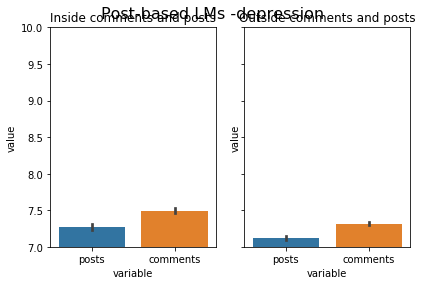

Importing  data/cleaned/sub_comments/Cooking_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/Cooking_author_counts_test_2017.csv ..... Done
Importing  data/cleaned/sub_posts/Cooking_posts_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/Cooking_author_counts_test_2017.csv ..... Done
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50


KeyboardInterrupt: 

In [60]:
# Posts
for s in subs:
    
    (gap_comments, entropy_comments), (gap_posts, entropy_posts) = get_acc_gap_post(post_based_slms[s], s)
    entropy_posts, entropy_comments = flatten_entropies(entropy_posts, entropy_comments)
    df_inside_post_and_comments, df_outside_post_and_comments = group_inside_outside(entropy_posts, entropy_comments) 

    
    # plot inside vs inside, and outside vs. outside
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

    sns.barplot(x='variable', y='value', data=df_inside_post_and_comments.melt(), ax=axs[0])
    axs[0].set_title('Inside comments and posts')
    axs[0].set_ylim([6, 10])

    sns.barplot(x='variable', y='value', data=df_outside_post_and_comments.melt(), ax=axs[1])
    axs[1].set_title('Outside comments and posts')
    axs[1].set_ylim([6, 10])

    fig.suptitle('Post-based LMs -' + s, fontsize=16)
    fig.savefig('data/figs/post_based_LMs_'+s+'_entropy_charts')
    plt.show()

Importing  data/cleaned/sub_comments/depression_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/depression_author_counts_test_2017.csv ..... Done
Importing  data/cleaned/sub_posts/depression_posts_2017.csv ..... 

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


Done
Importing  data/cleaned/test/2017/author_counts/depression_author_counts_test_2017.csv ..... Done
Getting avg acc gap for comments with passed slms
Calculating cross entropy for month 1 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


Saving acc gap for month 1
Calculating cross entropy for month 2 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 2
Calculating cross entropy for month 3 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 3
Calculating cross entropy for month 4 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 4
Calculating cross entropy for month 5 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 5
Calculating cross entropy for month 6 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 6
Calculating cross entropy for month 7 .....
sampled active users: 5 sampled outside

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


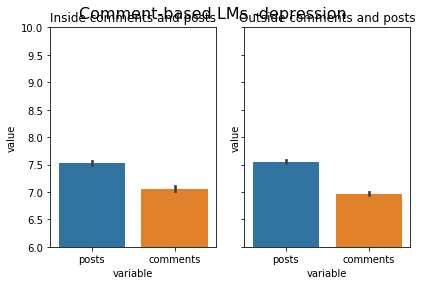

Importing  data/cleaned/sub_comments/Cooking_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/Cooking_author_counts_test_2017.csv ..... Done
Importing  data/cleaned/sub_posts/Cooking_posts_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/Cooking_author_counts_test_2017.csv ..... Done
Getting avg acc gap for comments with passed slms
Calculating cross entropy for month 1 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 1
Calculating cross entropy for month 2 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 2
Calculating cross entropy for month 3 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 3
Calculating cross entropy for month 4 .....
sampled active users: 5 sampled outside 

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


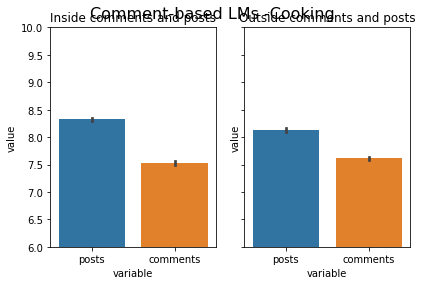

Importing  data/cleaned/sub_comments/Naruto_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/Naruto_author_counts_test_2017.csv ..... Done
Importing  data/cleaned/sub_posts/Naruto_posts_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/Naruto_author_counts_test_2017.csv ..... Done
Getting avg acc gap for comments with passed slms
Calculating cross entropy for month 1 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 1
Calculating cross entropy for month 2 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 2
Calculating cross entropy for month 3 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 3
Calculating cross entropy for month 4 .....
sampled active users: 5 sampled outside user

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


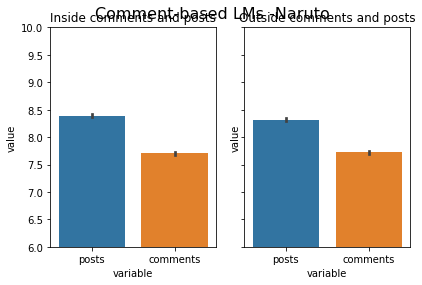

Importing  data/cleaned/sub_comments/BabyBumps_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/BabyBumps_author_counts_test_2017.csv ..... Done
Importing  data/cleaned/sub_posts/BabyBumps_posts_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/BabyBumps_author_counts_test_2017.csv ..... Done
Getting avg acc gap for comments with passed slms
Calculating cross entropy for month 1 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 1
Calculating cross entropy for month 2 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 2
Calculating cross entropy for month 3 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 3
Calculating cross entropy for month 4 .....
sampled active users: 5 sampled 

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


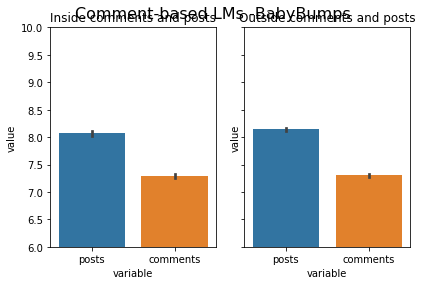

Importing  data/cleaned/sub_comments/pics_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/pics_author_counts_test_2017.csv ..... Done
Importing  data/cleaned/sub_posts/pics_posts_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/pics_author_counts_test_2017.csv ..... Done
Getting avg acc gap for comments with passed slms
Calculating cross entropy for month 1 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 1
Calculating cross entropy for month 2 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 2
Calculating cross entropy for month 3 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 3
Calculating cross entropy for month 4 .....
sampled active users: 5 sampled outside users: 50
sa

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


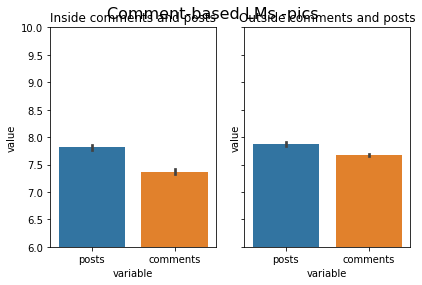

Importing  data/cleaned/sub_comments/science_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/science_author_counts_test_2017.csv ..... Done
Importing  data/cleaned/sub_posts/science_posts_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/science_author_counts_test_2017.csv ..... Done
Getting avg acc gap for comments with passed slms
Calculating cross entropy for month 1 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 1
Calculating cross entropy for month 2 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 2
Calculating cross entropy for month 3 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 3
Calculating cross entropy for month 4 .....
sampled active users: 5 sampled outside 

KeyboardInterrupt: 

In [63]:
# comments
for s in subs:
    
    (gap_comments, entropy_comments), (gap_posts, entropy_posts) = get_acc_gap_comment(comment_based_slms[s], s)
    entropy_posts, entropy_comments = flatten_entropies(entropy_posts, entropy_comments)
    df_inside_post_and_comments, df_outside_post_and_comments = group_inside_outside(entropy_posts, entropy_comments) 

    
    # plot inside vs inside, and outside vs. outside
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

    sns.barplot(x='variable', y='value', data=df_inside_post_and_comments.melt(), ax=axs[0])
    axs[0].set_title('Inside comments and posts')
    axs[0].set_ylim([6, 10])

    sns.barplot(x='variable', y='value', data=df_outside_post_and_comments.melt(), ax=axs[1])
    axs[1].set_title('Outside comments and posts')
    axs[1].set_ylim([6, 10])

    fig.suptitle('Comment-based LMs -' + s, fontsize=16)
    fig.savefig('data/figs/comment_based_LMs_'+s+'_entropy_charts')
    plt.show()

## Do outside comments look more similar to inside posts than inside comments are to inside posts?

Here we will start with looking at if outside *comments* are more similar to inside *posts* than inside comments are to inside *posts*

Considering that posts and comments look pretty different in general, both will not be all that close, but ideally we will see that outside comments are closer to inside posts than inside comments are (and that outside comments are closer to inside posts than they are to inside comments)


### Outside comments are closer to inside posts than inside comments are: 

Get entropy of outside and inside *comments* using LMs trained on *posts*, check if outside comments have lower entropy compared to inside comments



In [ ]:
# Posts
for s in subs:
    (gap_comments, entropy_comments), (gap_posts, entropy_posts) = get_acc_gap_post(post_based_slms[s], s)
    
    entropy_posts, entropy_comments = flatten_entropies(entropy_posts, entropy_comments)
    df_posts_inside_outside, df_comments_inside_outside = group_comments_posts(entropy_posts, entropy_comments)
    
    # plot inside vs inside, and outside vs. outside
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

    sns.barplot(x='variable', y='value', data=df_posts_inside_outside.melt(), ax=axs[0])
    axs[0].set_title('Posts')
    axs[0].set_ylim([6, 9])

    sns.barplot(x='variable', y='value', data=df_comments_inside_outside.melt(), ax=axs[1])
    axs[1].set_title('Comments')
    axs[1].set_ylim([6, 9])

    fig.suptitle('Post-based LMs -' + s, fontsize=16)
    plt.show()

Importing  data/cleaned/sub_comments/depression_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/depression_author_counts_test_2017.csv ..... Done
Importing  data/cleaned/sub_posts/depression_posts_2017.csv ..... 

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


Done
Importing  data/cleaned/test/2017/author_counts/depression_author_counts_test_2017.csv ..... Done
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking a

In [68]:
entropy_posts, entropy_comments = flatten_entropies(entropy_posts, entropy_comments)

In [72]:
df_posts_inside_outside, df_comments_inside_outside = group_comments_posts(entropy_posts, entropy_comments)

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


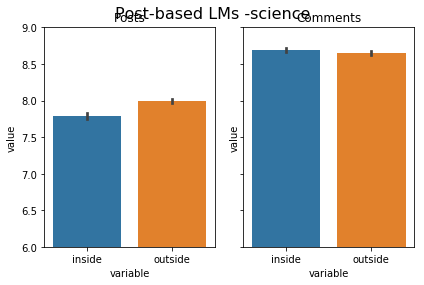

In [75]:
# plot inside vs inside, and outside vs. outside
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

sns.barplot(x='variable', y='value', data=df_posts_inside_outside.melt(), ax=axs[0])
axs[0].set_title('Posts')
axs[0].set_ylim([6, 9])

sns.barplot(x='variable', y='value', data=df_comments_inside_outside.melt(), ax=axs[1])
axs[1].set_title('Comments')
axs[1].set_ylim([6, 9])

fig.suptitle('Post-based LMs -' + s, fontsize=16)
plt.show()


### Outside comments are closer to inside posts than they are to inside comments: 

Get entropy of inside posts and inside comments, and outside comments, look to see if outside comments are closer to posts than to comments, can use either comment or post based LMs 